In [33]:
import numpy as np
import torch
from torch import optim
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
from numpy.linalg import inv

def fit_basis(X, y, l = 1, max_iter=50, B_init: np.ndarray = None, return_opt=False):
    N, D = X.shape
    X = X if isinstance(X, torch.Tensor) else torch.tensor(X)
    dtype = X.dtype
    y = y if isinstance(y, torch.Tensor) else torch.tensor(y).to(dtype)
    B_init = B_init if B_init is not None else np.random.uniform(0, 1, size=(D, D))
    B = torch.tensor(B_init, dtype=dtype, requires_grad=True)
    loss_fn = lambda: -objective(B=B, X=X, y=y, l=l)[0]
    opt = lbfgs(loss_fn, [B], verbose=True, max_iter=max_iter, history_size=100)
    grad_integrals = objective(B=B, X=X, y=y, l=l)[1]
    grad_integrals, indices = torch.sort(grad_integrals,descending=True)
    B = B[:, indices]
    B_norm = B.square().sum(axis=0).sqrt()
    B = B / B_norm
    #print('Contribution of directions:', grad_integrals)
    if return_opt:
        return B.detach().numpy(), grad_integrals.detach().numpy(), opt
    else:
        return B.detach().numpy(), grad_integrals.detach().numpy()

def objective(B: torch.Tensor, X: torch.Tensor, y: torch.Tensor, l: float = 1):
    dtype = X.dtype
    lms = fit_local_linear_models(X, y, l=l)
    grads = [lm_to_grad(lm.coef_) for lm in lms] # N * (D)
    B_norm = B.square().sum(axis=0).sqrt()
    B_nml = B / B_norm
    B_inv = torch.inverse(B_nml)
    grads_B = torch.cat([B_inv.mm(grad).reshape(-1,1) for grad in grads], dim=1).t() # (N, D)
    grad_int = integral_approx(X, grads_B.abs()) # (D)
    return totvar(grad_int) / grad_int.sum(), grad_int

def fit_local_linear_models(X, y, l=1):
    lrs = []
    for x in X:
        w = [kernel_sqexp(x, xi, length_scale=l) for xi in X]
        lr = weighted_linear_regression(X, y, w)
        lrs.append(lr)
    return lrs

def totvar(x):
    """Total variation for discrete signals: https://en.wikipedia.org/wiki/Total_variation_denoising"""
    return x.diff().abs().sum()  # change abs() to square()

def lm_to_grad(coef):
    return torch.tensor(coef)[:, None]

def kernel_sqexp(x1, x2, length_scale=1, signal_sd=1, noise_sd=0):
    """Square exponential kernel

    Args:
        x1 (torch.tensor): Data point.
        x2 (torch.tensor): Data point.
        length_scale (torch.tensor): Length scale.
        signal_sd (torch.tensor): Signal standard deviation.
        noise_sd (torch.tensor): Noise standard deviation.

    Returns:
        torch.tensor: kernel value K(x1, x2)
    """
    term1 = -0.5 * torch.sum((x1 - x2) ** 2 / length_scale**2)
    return signal_sd**2 * torch.exp(term1) + noise_sd**2

def weighted_linear_regression(X, y, weights = None):
    return LinearRegression().fit(X, y, sample_weight=weights)

def integral_approx(X, g):
    """Approximate integrals of g component-wise

    Args:
        X (torch.tensor): (N, D) data matrix.
        g (torch.tensor): (N, D) function values.

    Returns:
        torch.tensor: component-wise integrals of g(X[:,i])
    """
    integrals = []
    for j in range(X.shape[1]):
        i = X[:, j].argsort() # trapz needs sorted x,y (not obvious from docs)
        I = torch.trapz(y=g[i,j], x=X[i, j]).reshape(1)
        integrals.append(I)
    return torch.cat(integrals)

def plot_data2D(X, y, B=None, scale=None):
    Z = X @ inv(B).T if B is not None else X
    if B is not None:
        origin = np.zeros(shape=(B.shape))
        plt.subplot(222)
        plt.quiver(*origin, B[0,:], B[1,:], color=['r','g'])
    
    plt.subplot(221)
    plt.scatter(Z[:,0], Z[:,1], s=1)
    plt.xlabel('x1')
    plt.ylabel('x2')  
    plt.subplot(223)
    plt.scatter(Z[:,0], y, s=1)
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.subplot(224)
    plt.scatter(Z[:,1], y, s=1)
    plt.xlabel('x2')
    plt.ylabel('y')
    plt.tight_layout()
    
    if scale is not None:
        Z = Z * scale
        plt.figure()
        plt.suptitle("Transformed data with scale")
        plt.subplot(121)
        plt.scatter(Z[:,0], y, s=1)
        plt.xlabel('x1')
        plt.ylabel('y')
        plt.subplot(122)
        plt.scatter(Z[:,1], y, s=1)
        plt.xlabel('x2')
        plt.ylabel('y')
        plt.tight_layout()

def plot_data_pairs(X, y):
    df = pd.DataFrame(np.hstack((X, y[:, None])), columns=[f'x{i+1}' for i in range(X.shape[1])] + ['y'])
    return sns.pairplot(df, corner=True)

def plot_3d(X, y):
    import plotly.express as px
    fig = px.scatter_3d(x=X[:,0], y=X[:,1], z=y, labels={'x': 'x1', 'y': 'x2', 'z': 'y'})
    fig.update_traces(marker_size=5)
    fig.show()
    
def lbfgs(
    loss_fn,
    parameters,
    lr=1,
    max_iter=2000,
    tolerance_grad=1e-8,
    tolerance_change=1e-12,
    history_size=5,
    line_search_fn="strong_wolfe",
    verbose=True,
):
    """Optimize a loss with LBFGS
    Args:
        loss_fn (callable): Loss function to minimize. Should be callable as loss_fn(), and its computation should involve the parameters. The result should be a torch.Tensor() with requires_grad=True.
        parameters (iterable(torch.tensor)): Parameters to optimize.
        lr (int, optional): Learning rate. Defaults to 1 (Pytorch: 1. Stan: 0.001).
        max_iter (int, optional): Maximum number of iterations. Defaults to 2000 (Pytorch: 200. Stan: 2000).
        tolerance_grad (float, optional): termination tolerance on first order optimality. Defaults to 1e-8 (Pytorch: 1e-5. Stan: 1e-8).
        tolerance_change (float, optional): termination tolerance on function value/parameter changes. Defaults to 1e-12 (Pytorch: 1e-9. Stan: 1e-8 for parameter changes and 1e-12 for log-density changes).
        history_size (int, optional): History size. Defaults to 5 (Pytorch: 100. Stan: 5).
        line_search_fn (str, optional): Line search function. Defaults to "strong_wolfe".
        verbose (bool, optional): If True, prints loss after each iteration. Defaults to True.
    Returns:
        torch.optim.lbfgs.LBFGS: Optimizer object.
        As a side-effect it optimizes the parameters.
    """
    opt = optim.LBFGS(
        parameters,
        lr=lr,
        max_iter=max_iter,
        tolerance_grad=tolerance_grad,
        tolerance_change=tolerance_change,
        history_size=history_size,
        line_search_fn=line_search_fn,
    )

    def closure():
        opt.zero_grad()
        loss = loss_fn()
        loss.backward()
        if verbose:
            print(f"Loss = {loss.item()}")
        return loss

    opt.step(closure)
    return opt

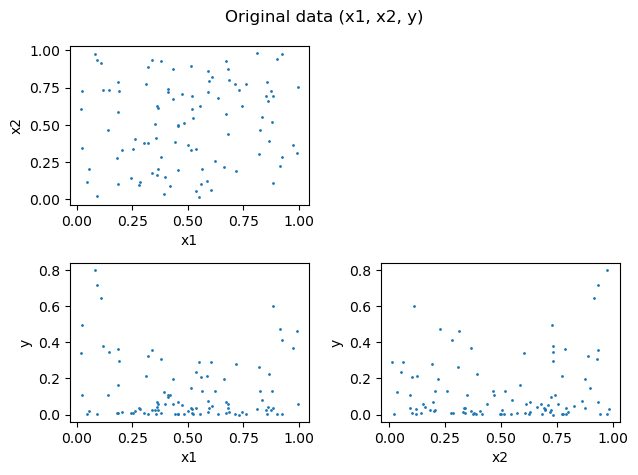

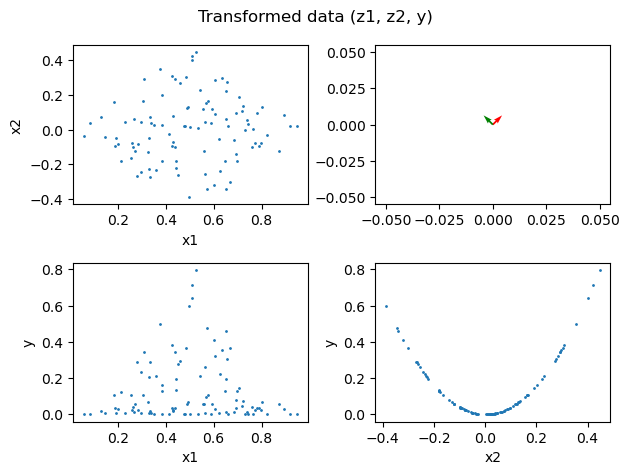

In [34]:
np.random.seed(2023)
N = 100
D = 2
f = lambda x: (x[:,0]-x[:,1])**2
X = np.random.uniform(0, 1, size=(N, D))
y = f(X)
B_bar = np.array([[1, -1],[1, 1]]) # we know beforehand this basis is relevant

plt.suptitle("Original data (x1, x2, y)")
plot_data2D(X, y)

plt.figure()
plt.suptitle("Transformed data (z1, z2, y)")
plot_data2D(X, y, B_bar)

In [35]:
np.random.seed(2023)
B_hat, grad_integrals, opt = fit_basis(X, y, l=0.1, max_iter=100, return_opt=True)

Loss = -0.11696631559372882
Loss = -0.3653598463549662
Loss = -0.4122415242467253
Loss = -0.8778904189952738
Loss = -0.7701287927708456
Loss = -0.8805186441813587
Loss = -0.8811783676482482
Loss = -0.8837673714358698
Loss = -0.8935634156581514
Loss = -0.8952893890549383
Loss = -0.8954760752118046
Loss = -0.895449779485765
Loss = -0.8954862656319489
Loss = -0.8954862914445034
Loss = -0.8954867582331829
Loss = -0.8954860486152737
Loss = -0.8954869813631147
Loss = -0.8954773721856706
Loss = -0.895487031363261
Loss = -0.8954867275499377
Loss = -0.8954870644440432
Loss = -0.8954870755098331
Loss = -0.8954870828291629
Loss = -0.895487090900085
Loss = -0.8954870948865745
Loss = -0.8954871017176923
Loss = -0.89548710422304
Loss = -0.8954871100978229
Loss = -0.8954871117864767
Loss = -0.8954870827490488
Loss = -0.8954871120182113
Loss = -0.8954871125057416
Loss = -0.8954871126594771
Loss = -0.8954871121566841
Loss = -0.8954871128660841
Loss = -0.895487112892294
Loss = -0.8954871129088995
Loss =

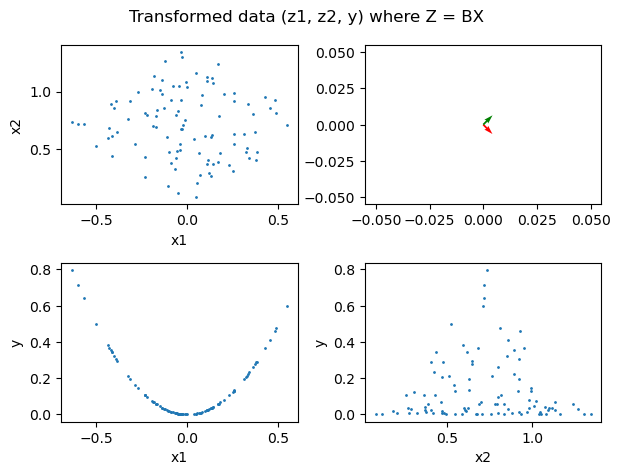

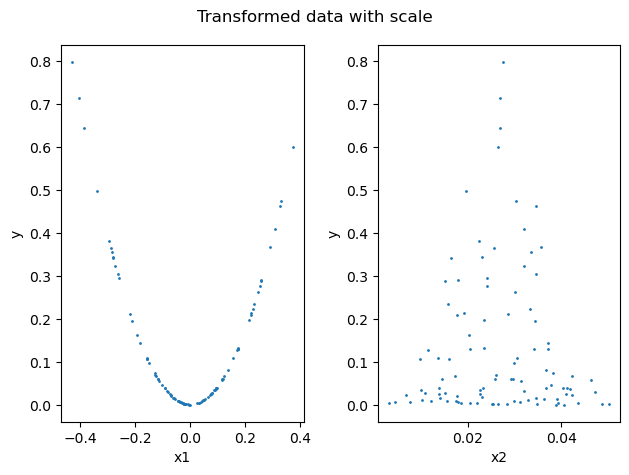

In [36]:
plt.suptitle('Transformed data (z1, z2, y) where Z = BX')
# Z = X @ (B_hat/np.abs(B_hat).max()).T
plot_data2D(X, y, B_hat, grad_integrals)

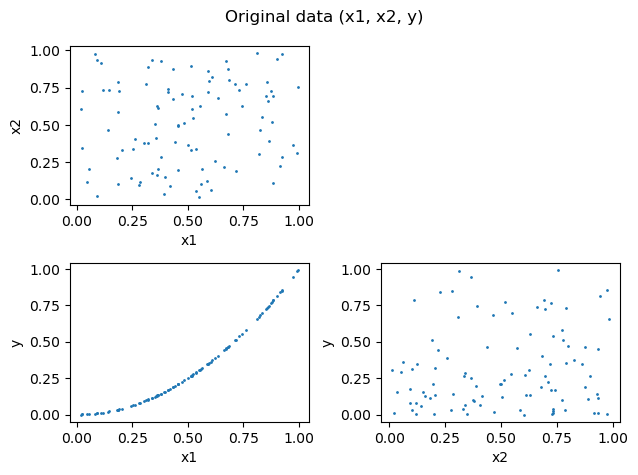

In [37]:
np.random.seed(2023)
N = 100
D = 2
f = lambda x: x[:,0]**2
X = np.random.uniform(0, 1, size=(N, D))
y = f(X)

plt.suptitle("Original data (x1, x2, y)")
plot_data2D(X, y)

In [38]:
np.random.seed(2023)
B_hat, grad_integrals, opt = fit_basis(X, y, l=0.1, max_iter=100, return_opt=True)

Loss = -0.7286606799032644
Loss = -0.2734894026962246
Loss = -0.8956817435910934
Loss = -0.9665341355242021
Loss = -0.9503028995955052
Loss = -0.9668509336283376
Loss = -0.9668966972517579
Loss = -0.966931582980168
Loss = -0.9669293234008971
Loss = -0.9669332386934135
Loss = -0.9669329600343439
Loss = -0.9669334111340278
Loss = -0.9669333723514529
Loss = -0.9669334279023701
Loss = -0.9669334206957367
Loss = -0.9669334275321616
Loss = -0.9669334283031475
Loss = -0.9669334282634002
Loss = -0.9669334283459304
Loss = -0.9669169441382912
Loss = -0.9669307960064232
Loss = -0.9669330080388485
Loss = -0.9669333612424791
Loss = -0.9669334176388203
Loss = -0.9669334266436481
Loss = -0.966933428081448
Loss = -0.9669334283109959


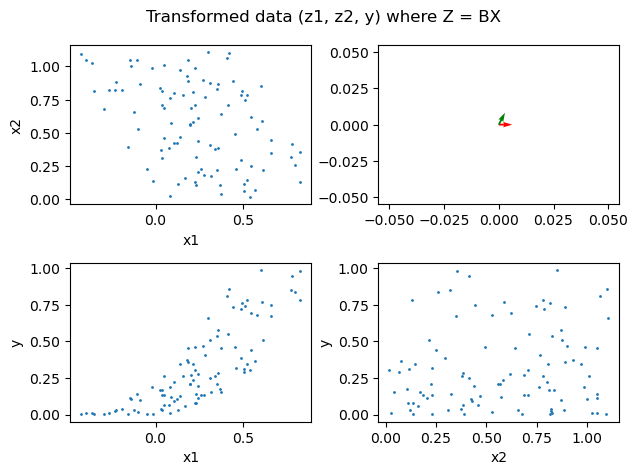

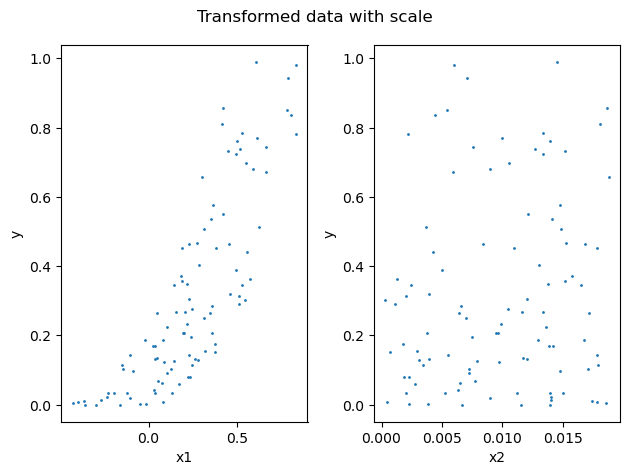

In [39]:
plt.suptitle('Transformed data (z1, z2, y) where Z = BX')
# Z = X @ (B_hat/np.abs(B_hat).max()).T
plot_data2D(X, y, B_hat, grad_integrals)